# Neural Network

----------
This neural network aims to predict the probability of default of companies based on quantitative features inspired by the training data.

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Data and initializing the neural network

In [2]:
# Load data
data_path = 'corporate_credit_risk.csv'  # Update this with the actual path to your CSV file
data = pd.read_csv(data_path)

# Prepare data
X = data.drop('Default', axis=1)
y = data['Default']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Build and train model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

## Computing ROC and AUC, and then improving the model

In [3]:
# Compute ROC curve and ROC area for the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Define the model and parameters for grid search
model = LogisticRegression(solver='liblinear')  # liblinear is good for small datasets and binary classification
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'class_weight': [None, 'balanced'],  # To handle class imbalance
    'penalty': ['l1', 'l2']  # Norm used in the penalization
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict and calculate AUC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"The AUC is: {roc_auc:.2f}")

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: Convergenc

The AUC is: 0.97


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Results

In [20]:
# Create a DataFrame to store all the contents of the file along with the predictions and probabilities
results_df = pd.DataFrame(X_test, columns=X.columns)
results_df['True_Default_Status'] = y_test.reset_index(drop=True)
results_df['Predicted_Default_Status'] = y_pred
results_df['Predicted_Probability_of_Default'] = y_pred_proba

# Output the DataFrame to a new CSV file
output_path = 'credit_risk_predictions.csv'
results_df.to_csv(output_path, index=False)

### Classification Report & Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       448
           1       0.36      0.71      0.48        34

    accuracy                           0.89       482
   macro avg       0.67      0.80      0.71       482
weighted avg       0.93      0.89      0.91       482

Confusion Matrix:


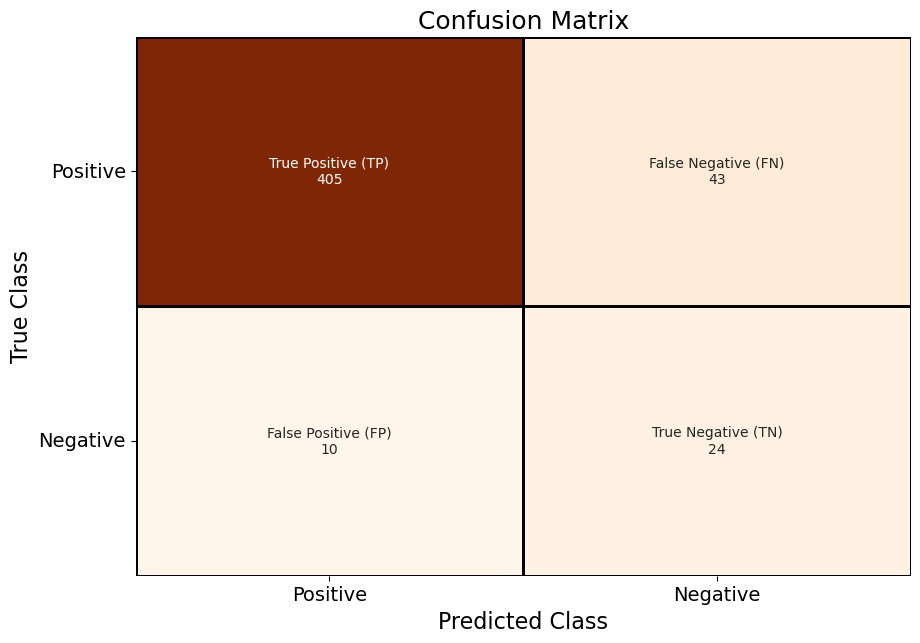

Sensitivity (Recall for class 1): 0.71
Specificity (True Negative Rate for class 0): 0.90


In [11]:
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Output results
print("Classification Report:")
print(classification_rep)

print("Confusion Matrix:")
# print(confusion_mat)
# Create labels for the confusion matrix with TP, FN, FP, TN
labels = np.array([['True Positive (TP)', 'False Negative (FN)'],
                   ['False Positive (FP)', 'True Negative (TN)']])

# Create annotations; combine actual count and labels
counts = ["{0:0.0f}".format(value) for value in confusion_mat.flatten()]
labels = (np.array(["{}\n{}".format(label, count) for label, count in zip(labels.flatten(), counts)])
          .reshape(2, 2))

# Plotting using seaborn's heatmap function
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=labels, fmt='', cmap='Oranges', cbar=False, linewidths=2, linecolor='black')

# Labels, title and ticks
label_font = {'size':'16'}  # Adjust to fit your style
plt.xlabel('Predicted Class', fontdict=label_font)
plt.ylabel('True Class', fontdict=label_font)
plt.title('Confusion Matrix', fontdict={'size':'18'})

tick_font = {'size':'14'}  # Adjust to fit your style
plt.xticks([0.5, 1.5], ['Positive', 'Negative'], fontsize=14)
plt.yticks([0.5, 1.5], ['Positive', 'Negative'], fontsize=14, rotation=0)

plt.show()

tn, fp, fn, tp = confusion_mat.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall for class 1): {sensitivity:.2f}")
print(f"Specificity (True Negative Rate for class 0): {specificity:.2f}")

### Classification (Rating Grades) & Uploading to CSV

In [12]:
thresholds = np.array([1/600, 1/300, 1/150, 1/30, 1/10, 1/5, 1/2, 1])
ratings = np.array(["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "CC", "D"])

thresholds = thresholds[::-1]
ratings = ratings[::-1]
    
# Digitize the probabilities to get the indices for ratings
indices = np.digitize(y_pred_proba, thresholds, right=True)
    
# Map the indices to ratings
predicted_ratings = ratings[indices]

# Create a DataFrame to store all the contents of the file along with the predictions and probabilities
results_df = pd.DataFrame(X_test, columns=X.columns)
results_df['True_Default_Status'] = y_test.reset_index(drop=True)
results_df['Predicted_Default_Status'] = y_pred
results_df['Predicted_Probability_of_Default'] = y_pred_proba
results_df['Predicted_Rating'] = predicted_ratings

# Output the DataFrame to a new CSV file
output_path = 'credit_risk_predictions.csv'
results_df.to_csv(output_path, index=False)

### Density Plot

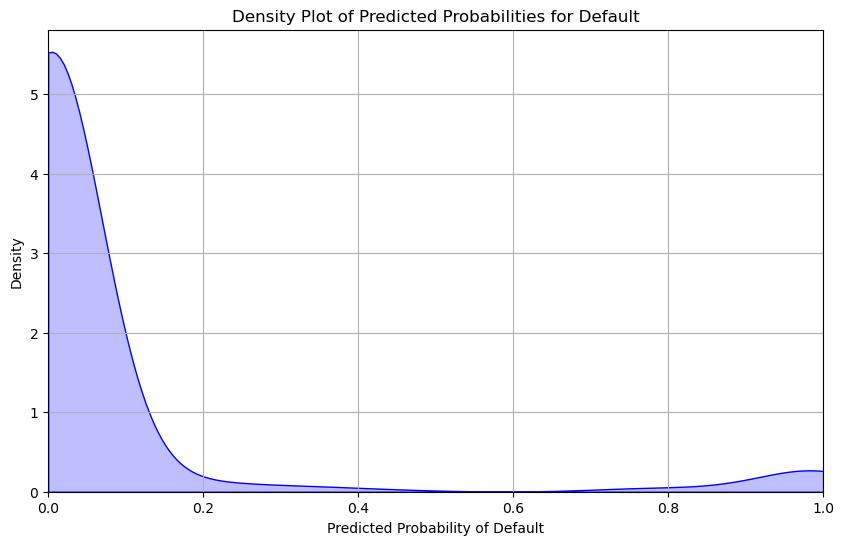

In [11]:
# Plot density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_proba, fill=True, color="blue", cut=0)
plt.xlim(0, 1)  # Ensure the x-axis is bounded between 0 and 1
plt.title('Density Plot of Predicted Probabilities for Default')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Density')
plt.grid(True)
plt.show()

### ROC Curve

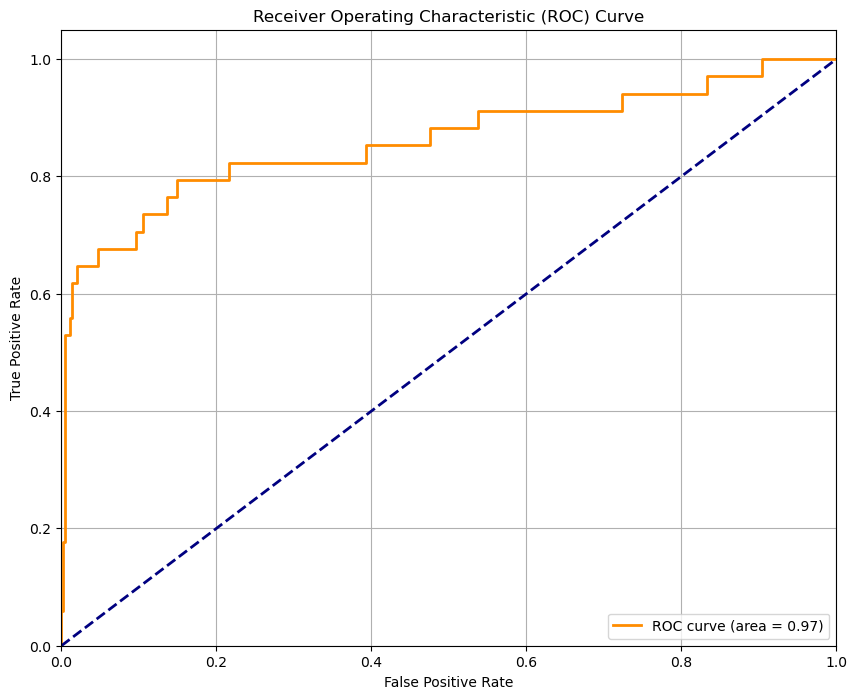

In [12]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()